In [1]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


### Data set-up

In [3]:
def get_sara():
    return ir_datasets.load('sara')

def sara_docs():
    for doc in sara_dataset.docs_iter():
        doc_id = doc.doc_id
        text = doc.text
        sens = doc.sensitivity
        text_method = doc.default_text()
        
        e = email.message_from_string(text_method)
        pl = e.get_payload()

        print(doc_id, sens)
        break

sara_dataset = get_sara()

In [4]:

def dataset_to_df():
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df


sara_df = dataset_to_df()


In [5]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)
value_counts = testing_sample.sensitivity.value_counts()

'''
doc_lengths = testing_sample.text.str.len()
cannot_load = testing_sample[doc_lengths > 12000]
value_counts = cannot_load.sensitivity.value_counts()
'''

doc_lengths = testing_sample.text.str.len()
temp_testing_sample = testing_sample[doc_lengths < 12000]
testing_sample = temp_testing_sample

sampled_indices = testing_sample.index
training_data = sara_df.drop(sampled_indices)

### Data Analysis

In [6]:
print(sara_df.head())

   doc_id                                               text  sensitivity
0  114715  Message-ID: <26804150.1075842955435.JavaMail.e...            0
1  229405  Message-ID: <23075367.1075853128311.JavaMail.e...            0
2  232795  Message-ID: <27422646.1075853196172.JavaMail.e...            0
3   62815  Message-ID: <4131316.1075840896739.JavaMail.ev...            0
4  118871  Message-ID: <12747077.1075843316348.JavaMail.e...            0


In [7]:
value_counts = sara_df.sensitivity.value_counts()
print(value_counts)

sensitivity
0    1491
1     211
Name: count, dtype: int64


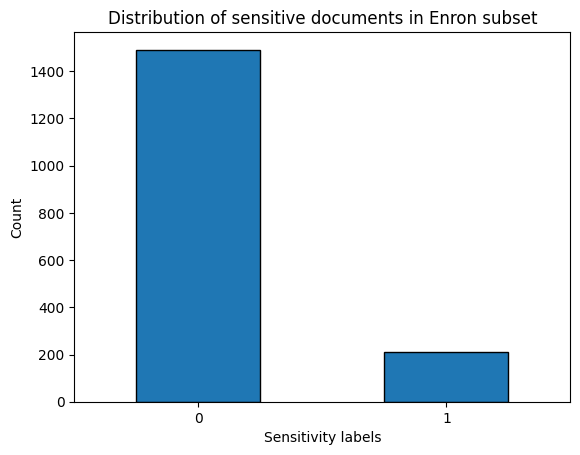

In [8]:

# Plotting the bar plot
value_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Sensitivity labels')
plt.ylabel('Count')
plt.title('Distribution of sensitive documents in Enron subset')
plt.xticks(rotation=0)
plt.show()

In [9]:
print(sara_df.text)

0       Message-ID: <26804150.1075842955435.JavaMail.e...
1       Message-ID: <23075367.1075853128311.JavaMail.e...
2       Message-ID: <27422646.1075853196172.JavaMail.e...
3       Message-ID: <4131316.1075840896739.JavaMail.ev...
4       Message-ID: <12747077.1075843316348.JavaMail.e...
                              ...                        
1697    Message-ID: <4760206.1075853182821.JavaMail.ev...
1698    Message-ID: <18686957.1075847598576.JavaMail.e...
1699    Message-ID: <3959000.1075847624851.JavaMail.ev...
1700    Message-ID: <15050098.1075847624899.JavaMail.e...
1701    Message-ID: <29023172.1075847627587.JavaMail.e...
Name: text, Length: 1702, dtype: object


In [10]:
doc_lengths = sara_df.text.str.len()
print(doc_lengths)

0        4697
1        2233
2        1192
3        5281
4        5419
        ...  
1697      835
1698     2299
1699     1551
1700     1564
1701    24948
Name: text, Length: 1702, dtype: int64


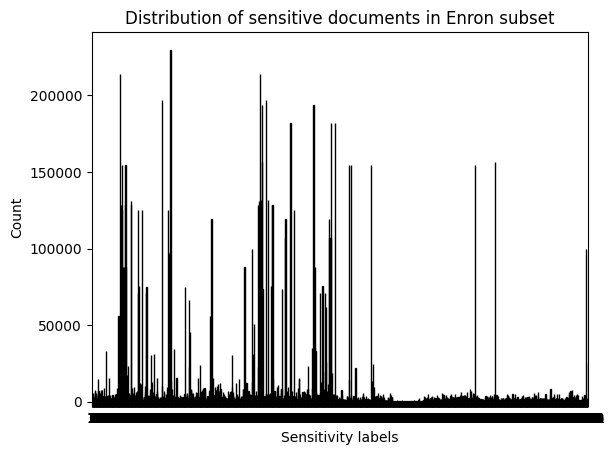

In [11]:
doc_lengths.plot(kind='bar', edgecolor='black')
plt.xlabel('Sensitivity labels')
plt.ylabel('Count')
plt.title('Distribution of sensitive documents in Enron subset')
plt.xticks(rotation=0)
plt.show()

In [12]:
doc_lengths

0        4697
1        2233
2        1192
3        5281
4        5419
        ...  
1697      835
1698     2299
1699     1551
1700     1564
1701    24948
Name: text, Length: 1702, dtype: int64

In [13]:
long_docs = sara_df[doc_lengths > 5000]

In [14]:
value_counts = long_docs.sensitivity.value_counts()
print(value_counts)

sensitivity
0    244
1     14
Name: count, dtype: int64


In [18]:
# Cannot load documents of length greater than ~12400. 109 problematic documents. However, longer documents begin to classify poorly.
cannot_load = sara_df[doc_lengths > 12400]
value_counts = cannot_load.sensitivity.value_counts()
print(value_counts)

sensitivity
0    100
1      9
Name: count, dtype: int64


### Llama 2 with SARA

In [ ]:
access_token = l2_token
model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_auth_token=access_token)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", use_auth_token=access_token, cache_dir=my_cache)

In [ ]:
def old_get_prompt_template(prompt):
  return f"""[INST] <<SYS>>
  You are a helpful, respectful and honest assistant. Always answer as helpfully as possible. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
  <</SYS>>
  The degree of sensitivity in text is regarded as how much personal information is exposed within the text. Classify the text into non-sensitive or sensitive.
  Text: {prompt}
  Sensitivity classification:[/INST]
  """

In [9]:
def base_prompt_template(document):
  return f"""[INST]
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attirbute:'.
  Attribute: 
  """

def context_prompt_template(document):
  return f"""[INST]
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text.
  When classifying the Text only consider personal information that is sensitive. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attirbute:'.
  Attribute: 
  """

def get_prompt_template(document, prompt):
   return prompt(document)

In [10]:
def llm_inference(document, prompt, model):
  inputs = tokenizer(get_prompt_template(document, prompt), return_tensors='pt')
  generation_config = GenerationConfig(
    # Unable to set temperature to 0 - https://github.com/facebookresearch/llama/issues/687 - use do_sample=False for greedy decoding
    do_sample=False,
    max_new_tokens=20,
  )
  output = model.generate(inputs=inputs.input_ids.cuda(), attention_mask=inputs.attention_mask.cuda(), generation_config=generation_config)
  return tokenizer.decode(output[0], skip_special_tokens=True)

def display_gen_text(output):
  return output[-20:]
  '''
  # Generates entire prompt + new tokens - cut out prompt from dislay
  end_template = output.find('[/INST]')
  return output[end_template:]
  '''

def prompt_to_reply(d, p):
  response = llm_inference(d, p, model)
  return display_gen_text(response)


In [11]:
# String matching on model response
def post_process_classification(classification, ground_truth):
    if 'non-sensitive' in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    elif 'sensitive' in classification.lower() and 'non-sensitive' not in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification


def clear_memory():
    # Prevents cuda out of memory
    torch.cuda.empty_cache()
    gc.collect()


# Dataset - dataframe, prompt_strategy - prompt function name
def llm_experiment(dataset, prompt_strategy=base_prompt_template):
    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    further_processing_required = {}
    # All model output
    model_responses = {}
    
    #total_samples = 50

    scikit_true = []
    scikit_pred = []

    for sample in dataset.iterrows():
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # To replace with appropriate pre-processing
        if len(sample_text) > 12000:
            continue
        
        classification = prompt_to_reply(sample_text, prompt_strategy)
        model_responses[sample[1].doc_id] = classification

        quadrant, pred = post_process_classification(classification, ground_truth)
        if pred == None:
            further_processing_required[sample[1].doc_id] = quadrant
            continue

        predictions[quadrant] = predictions.get(quadrant) + 1
        scikit_true.append(ground_truth)
        scikit_pred.append(pred)

        clear_memory()

        #total_samples -= 1
        #if total_samples == 0:
        #    break

    #print(predictions)
    return predictions, further_processing_required, model_responses, scikit_true, scikit_pred


#predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(sara_df, prompt_strategy)

### Evaluation summary

In [12]:
def basic_metrics(true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    bac = balanced_accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average=None)


def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()
 

#evaluation_summary("Llama-2", scikit_true, scikit_pred)

### ML methods

#### Dummy classifiers

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [7]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)

In [ ]:
def dummys(train, test):
    vectorizer = CountVectorizer()
    vectorizer.fit(train.text.tolist())

    train_features = vectorizer.transform(train.text.tolist())
    test_features = vectorizer.transform(test.text.tolist())
    train_labels = train.sensitivity
    test_labels = test.sensitivity

    dummy_mf = DummyClassifier(strategy="most_frequent")
    dummy_mf.fit(train_features, train_labels)
    mf_test_preds = dummy_mf.predict(test_features)
    evaluation_summary("Dummy MF", test_labels, mf_test_preds)


    dummy_rand = DummyClassifier(strategy="stratified")
    dummy_rand.fit(train_features, train_labels)
    rand_test_preds = dummy_rand.predict(test_features)
    evaluation_summary("Dummy Random stratified sampling", test_labels, rand_test_preds)

    return mf_test_preds, rand_test_preds


#dummys(training_data, testing_sample)

#### Logistic regression and SVM - with TF-IDF

In [22]:
def lr_svm_tdidf(train, test):
    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(train.text.tolist())
    test_tfidf = tfidf_vectoizer.transform(test.text.tolist())

    lr = LogisticRegression(max_iter=500)
    lr.fit(train_tfidf, train.sensitivity)
    lr_preds = lr.predict(test_tfidf)
    evaluation_summary("LR", test.sensitivity, lr_preds)

    svm_model = SVC()
    svm_model.fit(train_tfidf, train.sensitivity)
    svm_preds = svm_model.predict(test_tfidf)
    evaluation_summary("SVM", test.sensitivity, svm_preds)

    return lr_preds, svm_preds

### Results

In [6]:
mf_test_preds, rand_test_preds = dummys(training_data, testing_sample)
lr_preds, svm_preds = lr_svm_tdidf(training_data, testing_sample)

Evaluation for: Llama-2 with context manager
                   precision    recall  f1-score   support

Non-sensitive (0)      0.859     0.290     0.434       210
    Sensitive (1)      0.118     0.667     0.201        30

         accuracy                          0.338       240
        macro avg      0.489     0.479     0.318       240
     weighted avg      0.767     0.338     0.405       240



Confusion matrix:


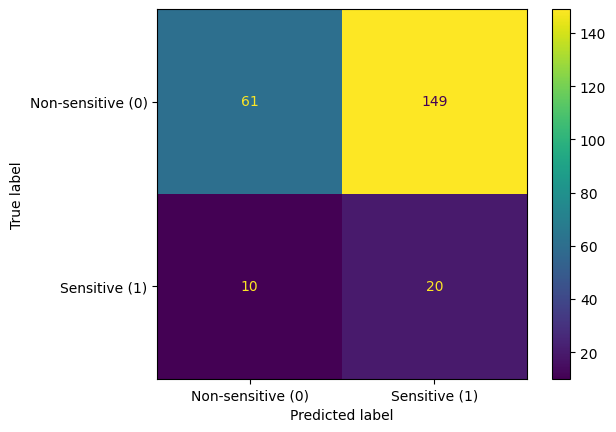

In [67]:
predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(testing_sample, context_prompt_template)
evaluation_summary("Llama-2 with context manager", scikit_true, scikit_pred)

In [68]:
def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    metrics_data[method] = metric_dict


metrics_data = {}

get_metric_dict('Dummy MF', testing_sample.sensitivity, mf_test_preds)
get_metric_dict('Dummy Rand', testing_sample.sensitivity, rand_test_preds)
get_metric_dict('LR TF-IDF', testing_sample.sensitivity, lr_preds)
get_metric_dict('SVM TF-IDF', testing_sample.sensitivity, svm_preds)
get_metric_dict('Llama-2', scikit_true, scikit_pred)
metrics_data

{'Dummy MF': {'accuracy': 0.8702290076335878,
  'f1_score': 0.8098457703692165,
  'balanced accuracy': 0.5},
 'Dummy Rand': {'accuracy': 0.7977099236641222,
  'f1_score': 0.7766065084511024,
  'balanced accuracy': 0.47084623323013414},
 'LR TF-IDF': {'accuracy': 0.8854961832061069,
  'f1_score': 0.8531428028434775,
  'balanced accuracy': 0.5838493292053664},
 'SVM TF-IDF': {'accuracy': 0.8854961832061069,
  'f1_score': 0.8571304649548924,
  'balanced accuracy': 0.5963622291021672},
 'Llama-2': {'accuracy': 0.3375,
  'f1_score': 0.40501886657486724,
  'balanced accuracy': 0.47857142857142854}}

In [69]:
metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index')
metrics_df

,accuracy,f1_score,balanced accuracy
Dummy MF,0.870229,0.809846,0.500000
Dummy Rand,0.797710,0.776607,0.470846
LR TF-IDF,0.885496,0.853143,0.583849
SVM TF-IDF,0.885496,0.857130,0.596362
Llama-2,0.337500,0.405019,0.478571
